In [33]:
import ROOT as r

r.gStyle.SetOptFit(1111)
import math
exp = math.exp
cos = math.cos
sin = math.sin
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
getBlinded = Blinders(FitType.Omega_a, 'Kim is having fun getting his omega_a blinded!')
omega = getBlinded.paramToFreq(0)

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [34]:
def generate_lt(hist, name):
    integral = r.TH1D('integral_{}'.format(name),'integral_{}'.format(name),4691,0,4691*0.1492)
    running_sum = 0
    
    for i in range(201,4691):
        running_sum = 0
        for j in range(200,i):
            running_sum += hist.GetBinContent(j+1)*exp(hist.GetBinCenter(j+1)/64.4)
        integral.SetBinContent(i+1,running_sum)
        
    return integral

def set_parameters(func, parameters):
    for i in range(func.GetNpar()):
        func.SetParameter(i,parameters[i])

In [35]:
wiggle_files = []
lm_files = []
datasets = ['all']

for index in datasets:
    wiggle_files.append(r.TFile('./run2{0:}_Tpu_seedscan.root'.format(index)))
    lm_files.append(r.TFile('run2{0:}_lm.root'.format(index)))

In [38]:
hist_wiggle = []
hist_lm = []
hist_lt = []

for dataset_num in range(len(datasets)):

    print('Preparing histograms for dataset run2{}'.format(datasets[dataset_num]))
    
    hist_wiggle.append(wiggle_files[dataset_num].Get('wiggle_T_all_def_seed0'))
    hist_wiggle[-1].SetName('run2{:s}_wiggle'.format(datasets[dataset_num]))
    
    hist_lm.append(lm_files[dataset_num].Get('run2all_LM_spec'))
    hist_lt.append(generate_lt(lm_files[dataset_num].Get('run2all_LM_spec'),datasets[dataset_num]))

Preparing histograms for dataset 3all


In [39]:
def blinded_wiggle_cbo_lm(x, p):
    
    t = x[0]
    
    norm = p[0]
    tau = p[1]
    A_c = p[2]
    A_s = p[3]
    R = p[4]

    tau_cbo = p[5]
    A_cbo_c = p[6]
    A_cbo_s = p[7]
    omega_cbo = p[8]
    
    C = p[9]
    
    binx = lt.GetXaxis().FindBin(t)
    L = lt.GetBinContent(binx)
    
    return norm * (1 - C*L) * exp(-t/tau) * (1 - A_c*cos(omega*(1+R*1e-6)*t) + A_s*sin(omega*(1+R*1e-6)*t)) * (1 - exp(-t/tau_cbo) * (A_cbo_c*cos(omega_cbo*t)+A_cbo_s*sin(omega_cbo*t)))

In [40]:
func1 = r.TF1("func1", blinded_wiggle_cbo_lm, 202*0.1492,4357*0.1492,10)
func1.SetParNames('N','#tau','A^{c}','A^{s}','R','#tau_{cbo}','A^{c}_{cbo}','A^{s}_{cbo}','#omega_{cbo}','#kappa_{loss}')
func1.SetParameters(3.5e6,64.4,0.2,-0.3,-70,250,-0.003,0.0003,2.33,1e-9)
func1.SetParLimits(1,55,70)
func1.SetParLimits(5,50,600)
func1.SetLineColor(2)
func1.SetNpx(1000)

Pre-fitting the wiggle plot for dataset 3all


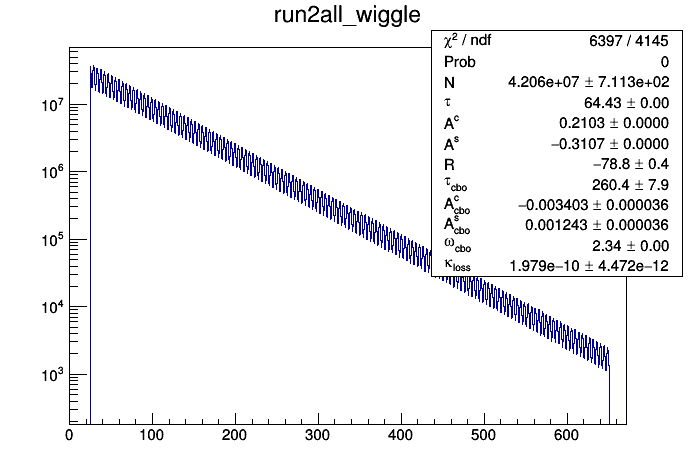

In [48]:
canvs = []
full_fit_parameters_allds = []

for dataset_num in range(len(datasets)):

    print('Pre-fitting the wiggle plot for dataset 3{}'.format(datasets[dataset_num]))

    canvs.append(r.TCanvas())
    full_fit_parameters = []
    func1.SetParameter(0,hist_wiggle[dataset_num].GetEntries()/400)
    lt = hist_lt[dataset_num]
    hist_wiggle[dataset_num].Draw('hist')
    hist_wiggle[dataset_num].SetTitle('run2{:s}_wiggle'.format(datasets[dataset_num]))
    hist_wiggle[dataset_num].Fit('func1','REMQ')
    
    for i in range(func1.GetNpar()):
        full_fit_parameters.append(func1.GetParameter(i))
        
    full_fit_parameters_allds.append(full_fit_parameters)
    
    canvs[-1].Draw()
    canvs[-1].SetLogy()

Fitting dataset 2all
--> Fitting for wiggle plot with pileup multiplier of 0.70
----> Wiggle plot fitted successfully, reduced chi2: 1.158358
--> Fitting for wiggle plot with pileup multiplier of 0.80
----> Wiggle plot fitted successfully, reduced chi2: 1.143833
--> Fitting for wiggle plot with pileup multiplier of 0.90
----> Wiggle plot fitted successfully, reduced chi2: 1.139427
--> Fitting for wiggle plot with pileup multiplier of 1.00
----> Wiggle plot fitted successfully, reduced chi2: 1.145136
--> Fitting for wiggle plot with pileup multiplier of 1.10
----> Wiggle plot fitted successfully, reduced chi2: 1.160950
--> Fitting for wiggle plot with pileup multiplier of 1.20
----> Wiggle plot fitted successfully, reduced chi2: 1.186857
--> Fitting for wiggle plot with pileup multiplier of 1.30
----> Wiggle plot fitted successfully, reduced chi2: 1.222841


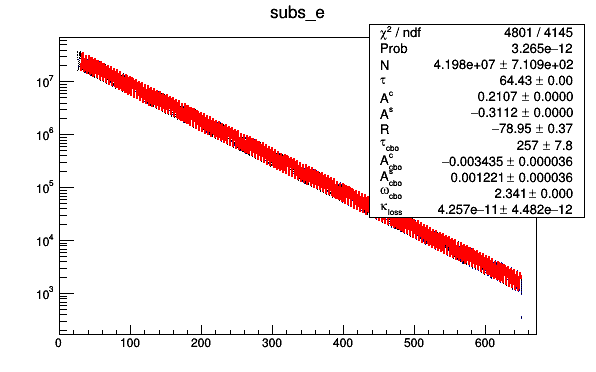

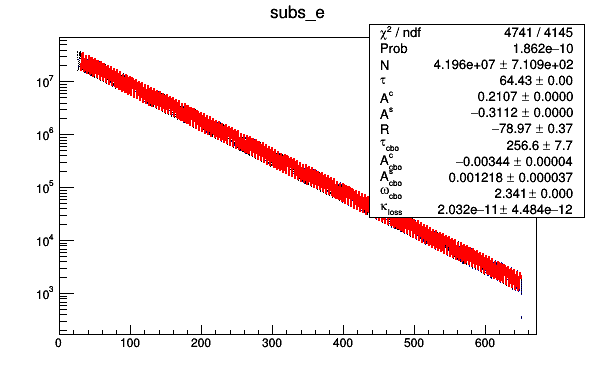

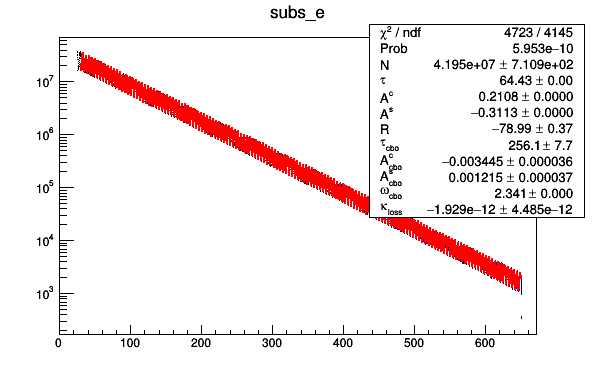

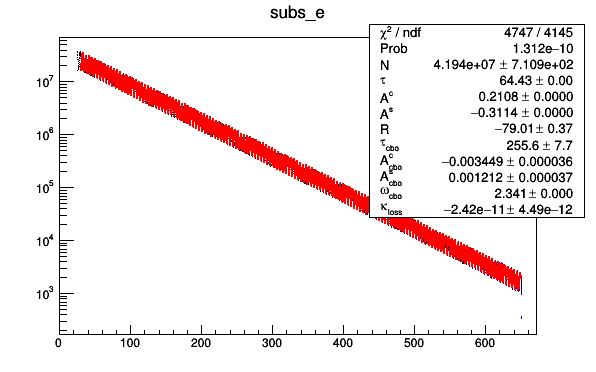

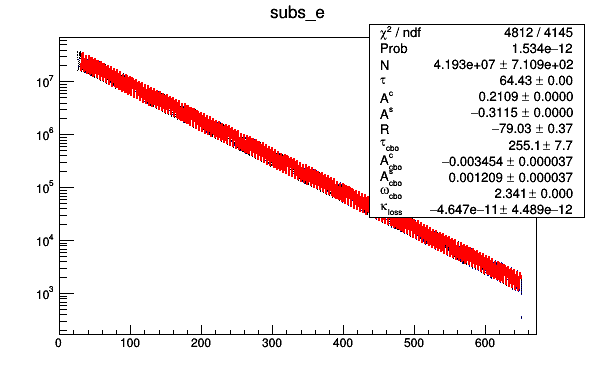

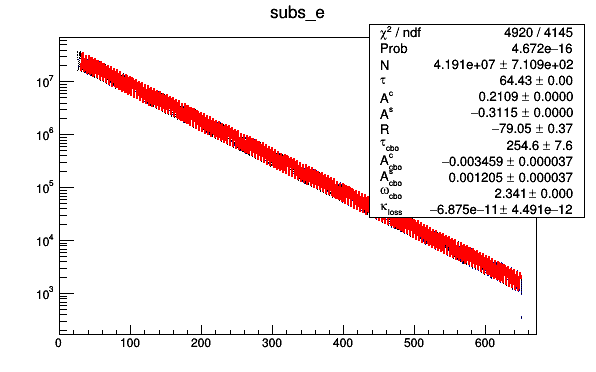

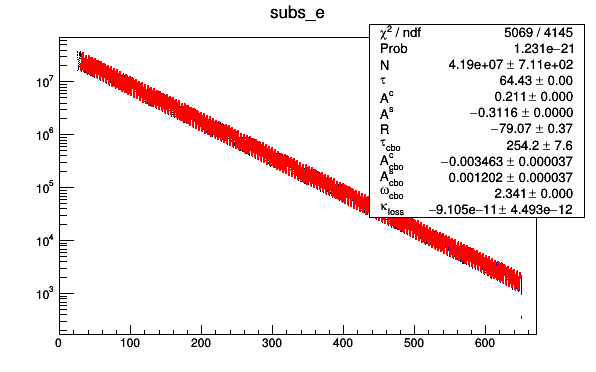

In [42]:
wiggles_afterpuc = []
canvs1 = []
pum_graphs = []
kloss_graphs = []

scan_mup = [0.7,0.8,0.9,1.0,1.1,1.2,1.3]

for ds_num in range(len(datasets)):
# for ds_num in range(1):

    print('Fitting dataset 2{}'.format(datasets[ds_num]))
    pum_graph = r.TGraphErrors()
    pum_graph.SetTitle('Dataset 2{}, Pileup Multiplier Scan; Pileup Multiplier; R [ppm]'.format(datasets[ds_num]))
    kloss_graph = r.TGraphErrors()
    kloss_graph.SetTitle('Dataset 2{}, Pileup Multiplier Scan; Pileup Multiplier; kloss'.format(datasets[ds_num]))
    lt = hist_lt[ds_num]

    for scan_num in range(7):
        
        #reduced_chi2 = 100
        print('--> Fitting for wiggle plot with pileup multiplier of {:.2f}'.format(scan_mup[scan_num]))
        canvs1.append(r.TCanvas('','',600,400))
        hist = wiggle_files[ds_num].Get('pileup_mulscan_{0:.2f}'.format(scan_mup[scan_num]))
        wiggles_afterpuc.append(hist)
                        
        #while reduced_chi2 > 1.3:
        if scan_num == 0:
            set_parameters(func1,full_fit_parameters_allds[ds_num])
        
        func1.SetParameter(0,hist.GetEntries()/400)
        hist.Fit(func1,'REMQ')
        chi2 = func1.GetChisquare()
        ndf = func1.GetNDF()
        reduced_chi2 = chi2/ndf
        
        print('----> Wiggle plot fitted successfully, reduced chi2: {:2f}'.format(reduced_chi2))

        pum_graph.SetPoint(pum_graph.GetN(),scan_mup[scan_num],func1.GetParameter(4))
        pum_graph.SetPointError(pum_graph.GetN()-1,0,func1.GetParError(4))
        kloss_graph.SetPoint(kloss_graph.GetN(),scan_mup[scan_num],func1.GetParameter(9))
        kloss_graph.SetPointError(kloss_graph.GetN()-1,0,func1.GetParError(9))
        canvs1[-1].SetLogy()
        canvs1[-1].Draw()
        
    pum_graphs.append(pum_graph)
    kloss_graphs.append(kloss_graph)

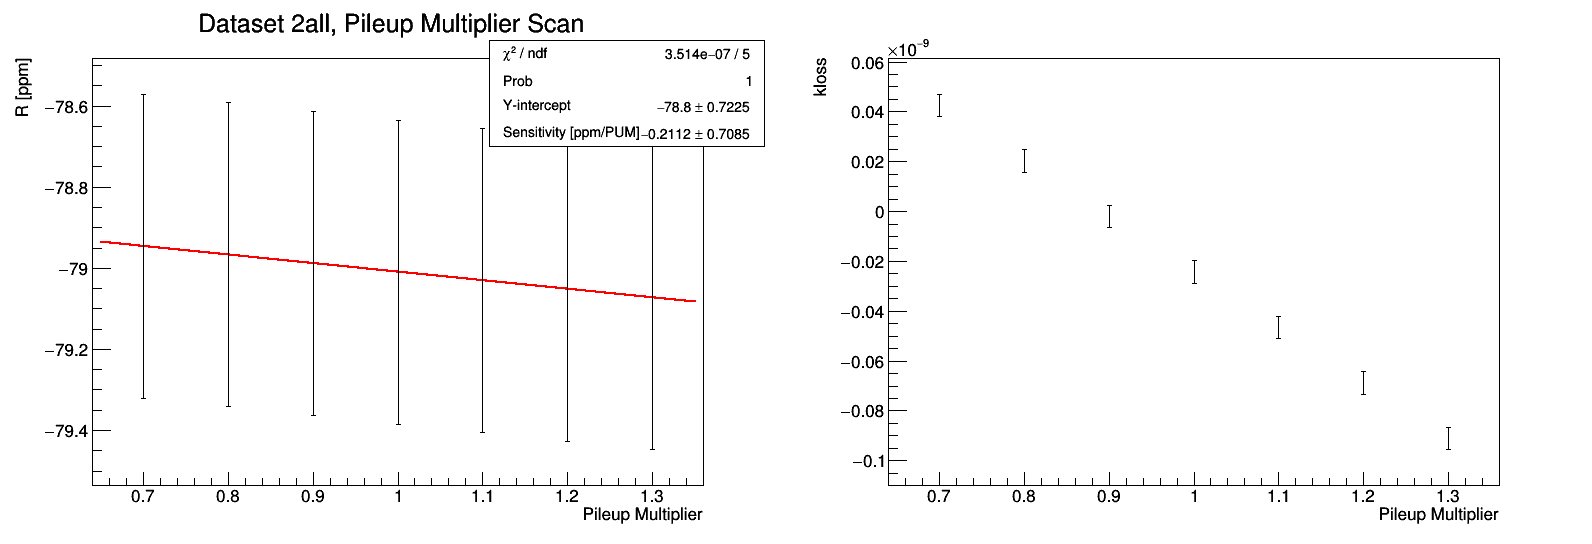

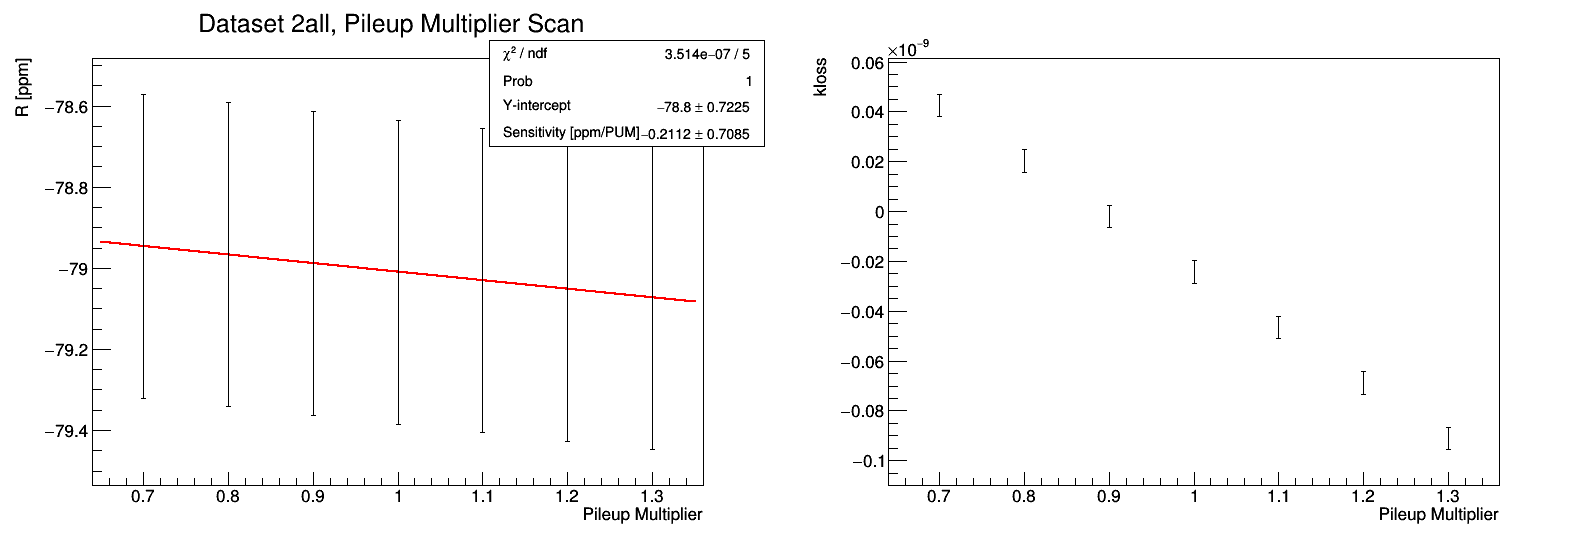

In [43]:
canvs2 = []
fit_func = r.TF1('fit_func','[0]+[1]*x',0.65,1.35)
fit_func.SetParNames('Y-intercept','Sensitivity [ppm/PUM]')
fit_func.SetLineColor(2)
fit_func.SetNpx(5000)

slope_hist = r.TH1D()

for i in range(len(pum_graphs)):
    canvs2.append(r.TCanvas('','',1600,600))
    canvs2[-1].Divide(2,1)
    canvs2[-1].cd(1)
    pum_graphs[i].Draw('AP')
    pum_graphs[i].Fit('fit_func','REMQ')
    slope_hist.Fill(datasets[i],fit_func.GetParameter(1))
    canvs2[-1].cd(2)
    kloss_graphs[i].Draw('AP')
    kloss_graphs[i].SetTitle('')
    canvs2[-1].Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


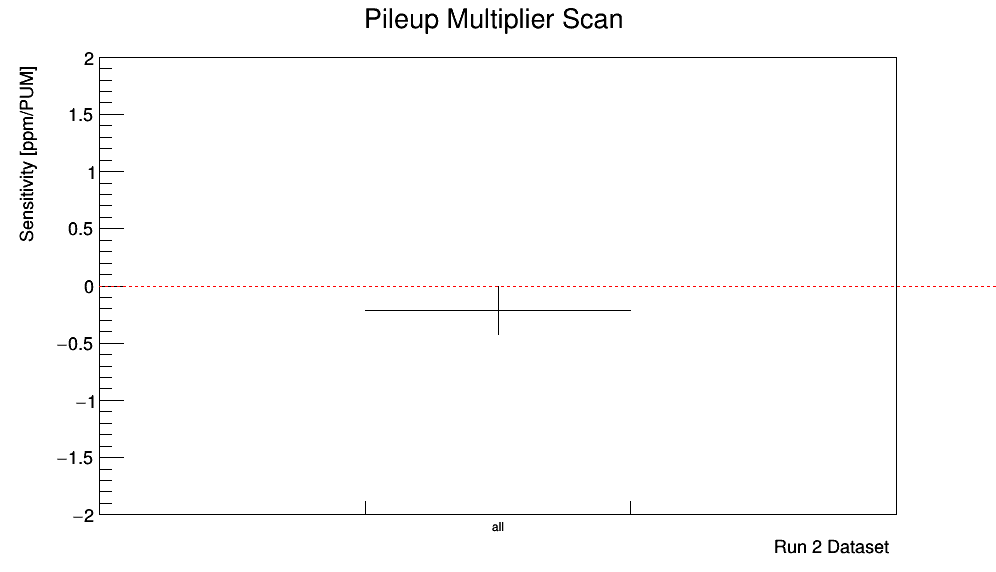

In [47]:
c2 = r.TCanvas('c2','c2',1000,600)
r.gStyle.SetOptStat(0)
line = r.TLine(-1,0,6,0)
line.SetLineColor(r.kRed)
line.SetLineStyle(2)
slope_hist.SetTitle('Pileup Multiplier Scan')
slope_hist.Draw('')
slope_hist.SetLineColor(1)
slope_hist.GetXaxis().SetTitle('Run 2 Dataset')
slope_hist.GetYaxis().SetTitle('Sensitivity [ppm/PUM]')
slope_hist.GetXaxis().SetRange(0,6)
slope_hist.GetYaxis().SetRangeUser(-2,2)

line.Draw()
c2.Draw()
